In [ ]:
import torch
import dill

payload = torch.load(open("outputs/pusht_lowdim_reproduction/00.11.58_train_diffusion_unet_hybrid_pusht_image_cnn_16/checkpoints/epoch=0300-test_mean_score=0.900.ckpt", "rb"), pickle_module=dill)

In [1]:
import torch
from torch.func import jacrev, vmap
x = torch.randn(1, 5)
jacobian = vmap(jacrev(torch.sin))(x)
print(jacobian.shape)

torch.Size([1, 5, 5])


In [2]:
torch.dot                            # [D], [D] -> []
batched_dot = torch.func.vmap(torch.dot)  # [N, D], [N, D] -> [N]
x, y = torch.randn(1, 5), torch.randn(1, 5)
print(batched_dot(x, y))

tensor([1.6291])


In [7]:
import time
# Setup
N = 10
def f(x):
    return x ** 2

x = torch.randn(N, requires_grad=True)
y = f(x)
basis_vectors = torch.eye(N)

time_start = time.time()
# Sequential approach
# jacobian_rows = [torch.autograd.grad(y, x, v, retain_graph=True)[0]
                #  for v in basis_vectors.unbind()]
jacobian_rows = [torch.autograd.grad(y, x, v, retain_graph=True)[0]
                 for v in basis_vectors.unbind()]
jacobian = torch.stack(jacobian_rows)
time_end = time.time()
print(f"Time taken: {time_end - time_start} seconds")

# Using `vmap`, we can vectorize the whole computation, computing the
# Jacobian in a single call to `autograd.grad`.
def get_vjp(v):
    return torch.autograd.grad(y, x, v)[0]
time_start = time.time()
# jacobian_vmap = vmap(get_vjp)(basis_vectors)
jacobian_vmap = vmap(jacrev(f))(basis_vectors)
time_end = time.time()
print(f"Time taken: {time_end - time_start} seconds")
assert torch.allclose(jacobian_vmap, jacobian)

Time taken: 0.0006630420684814453 seconds
Time taken: 0.001348257064819336 seconds


AssertionError: 

In [28]:
B = 1024
time_start = time.time()

time_start = time.time()
x = torch.randn(B, 5).to(device="cuda:0")
def f(x):
    return torch.sin(x)
jacobian = vmap(jacrev(f))(x)
time_end = time.time()
print(f"Time taken: {time_end - time_start} seconds")

time_start = time.time()
jacobian = [jacrev(f)(x[i]) for i in range(B)]
time_end = time.time()
print(f"Time taken: {time_end - time_start} seconds")


Time taken: 0.009607315063476562 seconds
Time taken: 0.1701350212097168 seconds


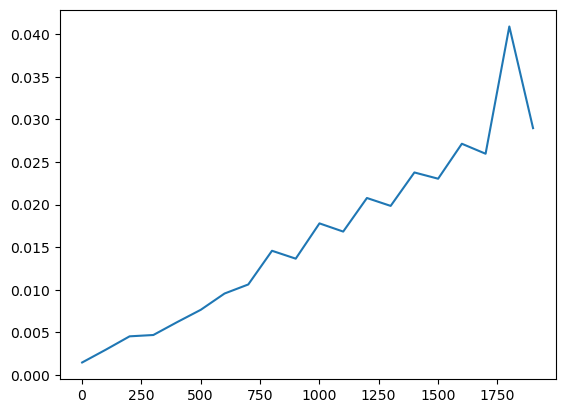

In [25]:
import numpy as np
import torch
from torch.func import jacrev, vmap
import time

elpased_time = list()
for scale in np.arange(1, 2000, 100):
    B = 1024*scale
    time_start = time.time()
    x = torch.randn(B, 5).to(device="cuda:0")
    def f(x):
        return torch.sin(x)
    jacobian = vmap(jacrev(f))(x)
    assert jacobian.shape == (B, 5, 5)
    time_end = time.time()
    elpased_time.append(time_end - time_start)

from matplotlib import pyplot as plt
plt.plot(np.arange(1, 2000, 100), elpased_time)
plt.show()

In [3]:
import cv2
print(cv2.videoio_registry)

AttributeError: module 'cv2.videoio_registry' has no attribute 'get_codecs'